In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
import seaborn as sns


<h1> Analisis de emiciones CO2 </h1>

In [3]:
#  ==== OBTENCION DE DATOS

# Obtén la ruta absoluta del arhivo actual
current_dir = os.getcwd() 

path_datasets = os.path.join(current_dir,"datasets")


path_co2 = os.path.join(path_datasets,"CO2 Emissions.csv") 

#Construimos el dataframe
base = pd.read_csv(path_co2)
nombres_nuevos = ['marca','modelo','clase','tamanio_motor','cilindros','transmision','combus_tipo','consumo_ciudad','consumo_autopista','consumo_comb','consumo_comb_mpg','emisiones_co2']
base.columns = nombres_nuevos

base

,marca,modelo,clase,tamanio_motor,cilindros,transmision,combus_tipo,consumo_ciudad,consumo_autopista,consumo_comb,consumo_comb_mpg,emisiones_co2
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


Analisis descriptivo basico

In [4]:
n = base.shape[0]

co2_media = base['emisiones_co2'].mean()
co2_std = base['emisiones_co2'].std()

print(f'El número de observaciones es: {n}')
print(f'El nivel de emisiones promedio es: {co2_media}')
print(f'El desvío estandar es: {co2_std}')
print(f'Y el coeficiente de variación es: {co2_std/co2_media*100}%')

El número de observaciones es: 7385
El nivel de emisiones promedio es: 250.58469871360867
El desvío estandar es: 58.512679394406476
Y el coeficiente de variación es: 23.35045982248109%


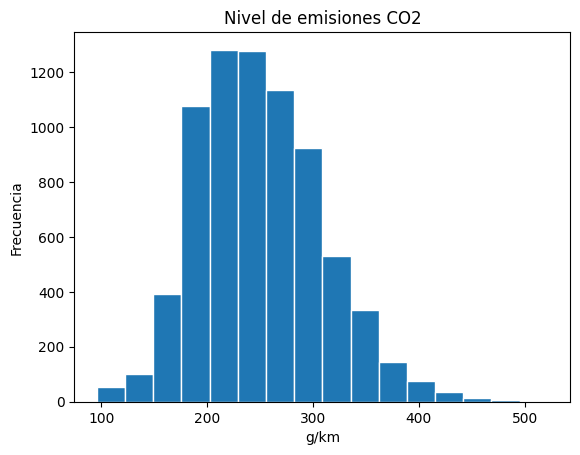

In [5]:
plt.hist(base['emisiones_co2'], bins=16, edgecolor = "white")
plt.title('Nivel de emisiones CO2')
plt.xlabel('g/km')
plt.ylabel('Frecuencia')
plt.show()

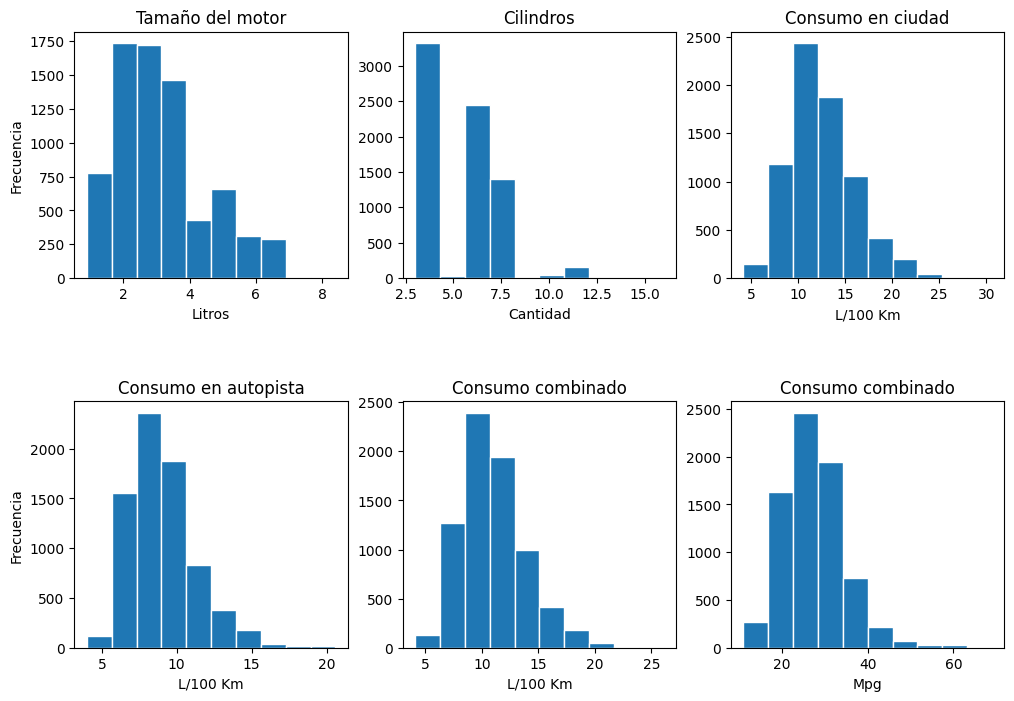

In [6]:
variables = ['tamanio_motor','cilindros','consumo_ciudad','consumo_autopista','consumo_comb','consumo_comb_mpg']
titulos = ['Tamaño del motor', 'Cilindros', 'Consumo en ciudad', 'Consumo en autopista','Consumo combinado','Consumo combinado']
xs = ['Litros','Cantidad','L/100 Km','L/100 Km','L/100 Km','Mpg']
ys = ['Frecuencia',None, None,'Frecuencia',None, None]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i in range(2):
  for j in range(3):
    ax[i,j].hist(base[variables[i*3+j]], edgecolor = "white")
    ax[i,j].set_title(titulos[i*3+j])
    ax[i,j].set_xlabel(xs[i*3+j])
    ax[i,j].set_ylabel(ys[i*3+j])

plt.subplots_adjust(hspace=0.5)
plt.show()

<Axes: >

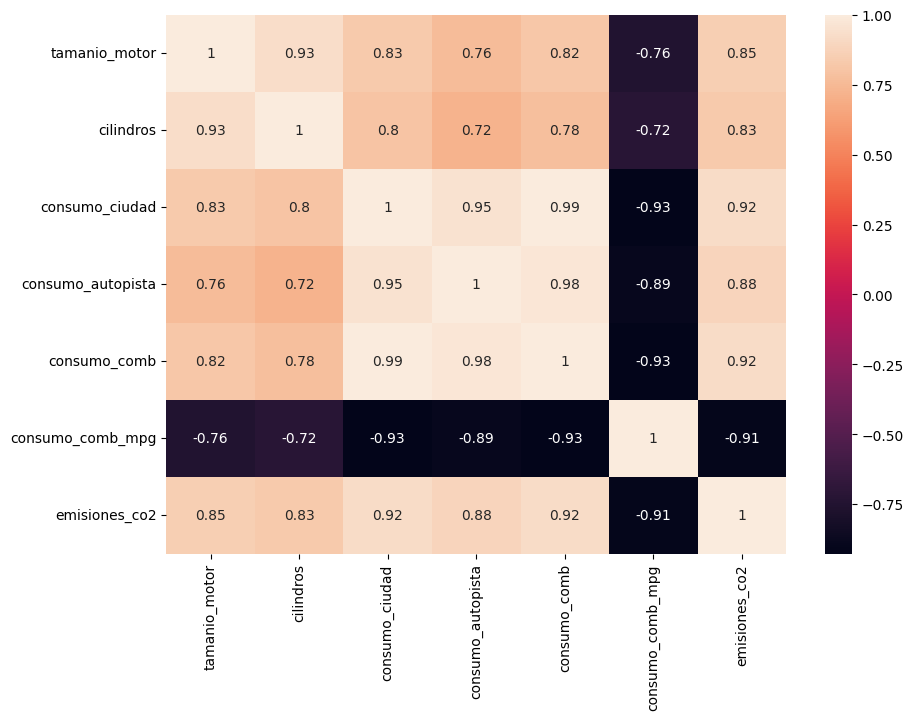

In [7]:
plt.figure(figsize = (10,7))
sns.heatmap(base.select_dtypes(include='number').corr(), annot = True, cmap = "rocket")

Si hacemos un scatter entre el tamaño del motor y las emisiones, podemos ver que a medida que aumenta el tamaño, relativamente aumenta la emision de CO2, esto tiene sentido logico.

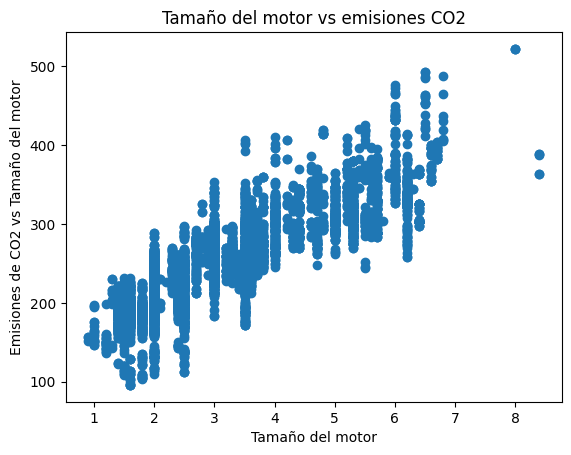

In [8]:
plt.scatter(base['tamanio_motor'], base['emisiones_co2'])
plt.title('Tamaño del motor vs emisiones CO2')
plt.xlabel('Tamaño del motor')
plt.ylabel('Emisiones de CO2 vs Tamaño del motor')
plt.show()


<p> Realizando lo mismo pero teniendo en cuenta el consumo que hay en la ciudad, obtendremos una relaciones "separadas" de la variable X e Y.</p>
En este caso, si nosotros condicionaramos la variable X, entonces obtendriamos posiblemente algun tipo de regresion distinta.


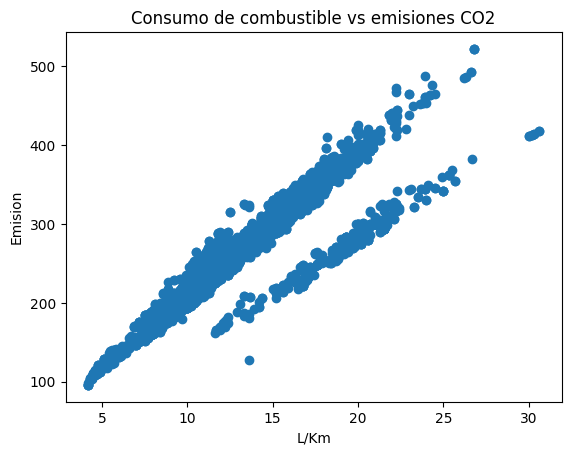

In [9]:
plt.scatter(base['consumo_ciudad'], base['emisiones_co2'])
plt.title('Consumo de combustible vs emisiones CO2')
plt.xlabel('L/Km')
plt.ylabel('Emision')
plt.show()

<h1> Regresiones por distintos metodos </h1>

Utilizando statsmodelos

In [10]:
X = base['consumo_ciudad']
X = sm.add_constant(X)
y = base['emisiones_co2']

#El comando OLS declara una regresion LINEAL que buscara el mejor valor de beta1 utilizando el metodo de minimos cuadrados ordinados. Recordar que en este caso
#Se busca minimizar la suma de los errores (u) que existe entre los valores estimativos y los reales.

reg1 = sm.OLS(y,X).fit()
print(reg1.summary())

"""
Explicacion de algunas salidas:

- Columna coef: es el valor de b_0 y b_1. Son los coeficientes de la regresion.

- Columna std err: es el error estandar de los cieficientes. representan cuanto desvio existe del valor. es decir por ejemplo
    que b_1 presenta un posible error de +- 0.996. 

- Intervalo del 95% de confianza: Representa un intervalo del 95% de confianza de que los coeficientes se encuentre entre -2. ee <= b_i <= +2. ee

"""

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 4.045e+04
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:43:28   Log-Likelihood:                -33630.
No. Observations:                7385   AIC:                         6.726e+04
Df Residuals:                    7383   BIC:                         6.728e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             57.5599      0.996     57.

'\nExplicacion de algunas salidas:\n\n- Columna coef: es el valor de b_0 y b_1. Son los coeficientes de la regresion.\n\n- Columna std err: es el error estandar de los cieficientes. representan cuanto desvio existe del valor. es decir por ejemplo\n    que b_1 presenta un posible error de +- 0.996. \n\n- Intervalo del 95% de confianza: Representa un intervalo del 95% de confianza de que los coeficientes se encuentre entre -2. ee <= b_i <= +2. ee\n\n\n'

In [11]:
X = base["consumo_ciudad"].values.reshape(-1, 1)
y = base["emisiones_co2"].values

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print('Coeficiente:', model.coef_) #Es el valor del beta 1. 
print('Intercepto:', model.intercept_) #Valor de beta 0.
print('Error cuadrático medio:', mse)
print('R^2:', r2)

Coeficiente: [15.37245896]
Intercepto: 57.55990260166175
Error cuadrático medio: 528.3806361133411
R^2: 0.8456503198972763


Prediccion usando el primer modelo creado

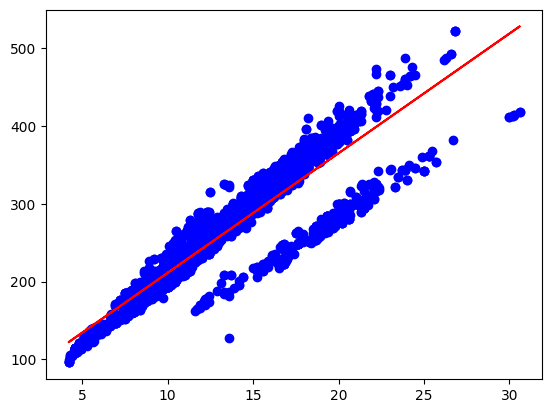

In [12]:
#Estamos haciendo una prediccion del CO2, y predicimos los valores de la Y en este caso usando los valores de 'consumo_ciudad'
predicciones = reg1.predict(sm.add_constant(base['consumo_ciudad']))

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.plot(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')
plt.show()

Realizamos el mismo grafico pero ahora añadiendo los intervalos de confianza que sostiene la pendiente

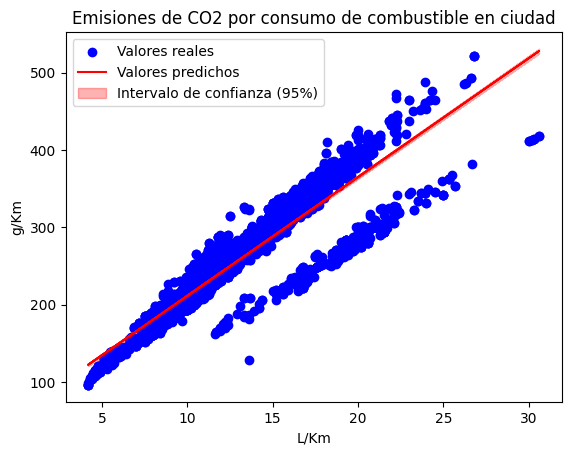

In [15]:
preds = reg1.get_prediction(sm.add_constant(base['consumo_ciudad']))
preds_media = preds.predicted_mean
int_confianza = preds.conf_int()

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.plot(base['consumo_ciudad'], preds_media, label='Valores predichos', color='red')
plt.fill_between(base['consumo_ciudad'], int_confianza[:, 0], int_confianza[:, 1], color='red', alpha=0.3, label='Intervalo de confianza (95%)')
plt.xlabel('L/Km')
plt.ylabel('g/Km')
plt.title('Emisiones de CO2 por consumo de combustible en ciudad')
plt.legend()
plt.show()